In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# mlQTLs: algorithm for QTLs mapping (and feature selection??)

I want to develop an ensemble L1norm approach for QTLs mapping, but it can be used also for feature selection on regression problems (maybe).

I took the idea (especially for classification tasks) from [this
manuscript](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5260053/)

### QTL mapping (main functionality)
You should use Rqtl for simulating crosses

In [10]:
#import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Create cell with R code

    Backcross

    No. individuals:    250 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    5 
        Autosomes:      1 2 3 4 5 

    Total markers:      268 
    No. markers:        65 38 50 55 60 
    Percent genotyped:  100 
    Genotypes (%):      AA:52.6  AB:47.4 


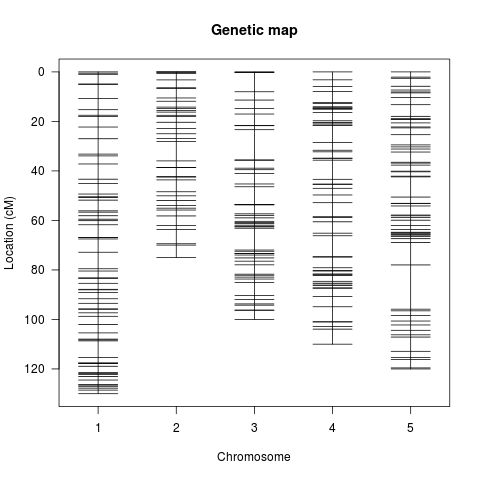

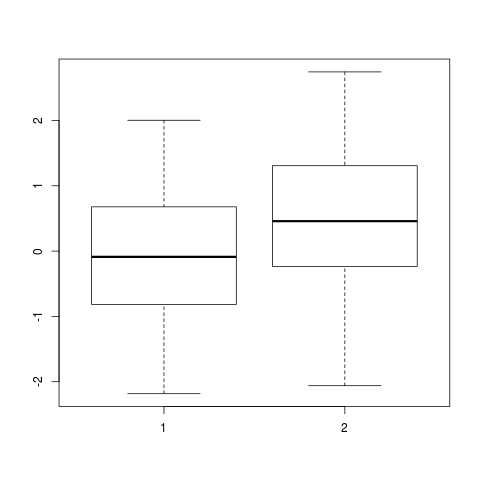

In [203]:
%%R
library(qtl)
L=c(130, 75, 100, 110, 120)
set.seed(42)
#markers_chr = ceiling(rnorm(5, 1000, 200))
set.seed(42)
mapD=sim.map(L, ceiling(L/2), eq.spacing=F, include.x=F)
plot(mapD)
bc_model = rbind(c(2, 20, 0.6))
BC_cross = sim.cross(mapD, n.ind=250, type='bc', model = bc_model)
p1 = subset(BC_cross$pheno[,1], BC_cross$qtlgeno[,1]==1)
p2 = subset(BC_cross$pheno[,1], BC_cross$qtlgeno[,1]==2)
boxplot(p1, p2)
print(summary(BC_cross))
write.cross(BC_cross, format='csv', filestem='BC_dominant_cross')

## Develop pipeline
The next cell hs the algorithm

Use of LassoCV

In [251]:
# main function
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.datasets import make_regression
from sklearn.svm import LinearSVR
from sklearn.linear_model import LassoCV
from scipy import stats

def optimize_weights(X, y, cv):
    alphas = 1/(X.shape[0]*np.logspace(-5, 4, 10))
    model = LassoCV(alphas=alphas, cv = cv, random_state=42, 
                    precompute=True, positive=True, n_jobs=-1)
    model.fit(X,y)
    return model.coef_
    
def mlQTLs_analysis(X, y, n_estimators=100,
                    max_samples = 0.8, cv = 5, random_state=42):
    '''main function that will call the other functions'''
    all_w = []
    for i in range(n_estimators):
        # loop over the number of estimators
        X_res, y_res = resample(X, y,
                                n_samples=int(np.ceil(X.shape[0]*max_samples)),
                                replace=True, random_state=i*random_state)
        w = optimize_weights(X_res, y_res, cv=cv)
        all_w.append(w)
    # now you will need to:
        #1) Calculate the stability score for each feature
        #2) Sum the scores
        #3) for optimization purpose I will return the full  coeff_array
    all_w = np.array(all_w)
    w= np.sum(all_w, axis=0)
    bin_matrix = np.where(all_w>0, 1, 0)
    s_scores = np.sum(bin_matrix, axis=0)/n_estimators
    return w, s_scores

## QTL

In [240]:
cross = pd.read_csv('BC_dominant_cross.csv', sep=',', header=0, skiprows=[1,2])
cross.head()

,phenotype,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,1.252148,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
1,0.329969,A,A,A,A,A,A,A,A,H,...,H,H,H,H,H,H,H,H,H,A
2,0.174287,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,A,A,A,A,A
3,0.126783,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
4,0.343584,A,A,A,A,A,A,A,A,A,...,A,A,A,H,H,H,H,H,H,H


In [241]:
# prepare Y and drop
y = cross['phenotype']
cross = cross.drop('phenotype', axis=1)
cross.head()

,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,D1M10,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,H,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
1,A,A,A,A,A,A,A,A,H,H,...,H,H,H,H,H,H,H,H,H,A
2,A,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,A,A,A,A,A
3,H,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
4,A,A,A,A,A,A,A,A,A,A,...,A,A,A,H,H,H,H,H,H,H


In [242]:
#prepare_array
d = {'A':0, 'H':1}
cross_numeric = cross.replace(to_replace=d)
cross_numeric.head()

,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,D1M10,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1


LASSOCV

In [243]:
from sklearn.model_selection import train_test_split
X = cross_numeric.values
y = y.values

weigths, scores = mlQTLs_analysis(X, y, n_estimators=100)

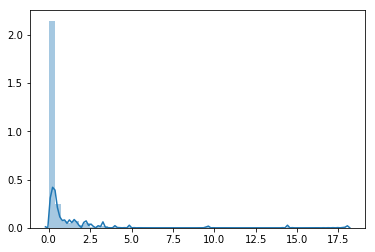

In [244]:
sns.distplot(weigths)
plt.show()

In [245]:
vals =weigths+scores
#sns.barplot(list(range(len(vals))), vals)
#plt.hlines(2140108.98839095, xmin=0, xmax=500 )
#plt.show()

In [247]:
scores

array([ 0.1,  0.1,  0.1,  1. ,  0.9,  2.7,  0.2,  0.1,  0.9,  3. ,  0.6,
        0.3,  0.2,  2.5,  1.4,  0. ,  0.6,  3. ,  1.9,  1.3,  0.8,  0.7,
        0. ,  0. ,  0. ,  1. ,  0.3,  0.2,  0.2,  0. ,  0.3,  1. ,  1.6,
        1.2,  0.7,  0.2,  0.2,  0. ,  0.1,  0. ,  0. ,  0. ,  0.4,  0.9,
        3.3,  0. ,  0.3,  0.1,  0.2,  0. ,  0.1,  0.2,  0.2,  0.2,  0. ,
        0.1,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.4,  1. ,
        0.6,  0.1,  0.2,  1.6,  0.9,  1.5,  1. ,  1. ,  1.5,  1.1,  1. ,
        1.5,  0.8,  2.2,  5.6,  1.3,  0.6,  5.2,  1.3,  2.5,  0. ,  0. ,
        0.1,  0.1,  0.1,  0. ,  0.2,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,
        0. ,  0. ,  0. ,  0.1,  0.1,  0.1,  0. ,  0.4,  0.4,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0.1,
        0.1,  0.1,  0. ,  0.8,  0.7,  0. ,  0. ,  0

In [248]:
print(np.percentile(vals, q=[50, 75, 90, 95, 99]))
q = np.percentile(vals, q=99)
q

[  0.13090549   0.71841893   2.39750895   3.81805194  10.35388062]


10.353880615749675

In [249]:
new_frame = pd.DataFrame({'markers_ID': cross_numeric.columns, 'Vals' :vals})
new_frame.head()

,Vals,markers_ID
0,0.152969,D1M1
1,0.100000,D1M2
2,0.100000,D1M3
3,1.824066,D1M4
4,0.900000,D1M5


In [250]:
new_frame[new_frame['Vals']>=q]

,Vals,markers_ID
80,23.585423,D2M16
83,14.794588,D2M19
266,21.321746,D5M59


In [214]:
new_frame[new_frame['Vals']>=q]

,Vals,markers_ID
80,18.545423,D2M16
83,10.114588,D2M19
266,15.111746,D5M59


## Final resolution

**Use np.sum and establish threshold as 99th percentile.
In addition the use of w+s is better also for low effect QTLs**

This option works kind of well with small effects single QTLs (ration 0.6 you can still identify good markers)
It would be interesting to evaluate the number of iterations depending on the QTL effect.

BTW you should check the LassoCV coefficient distribution as well.

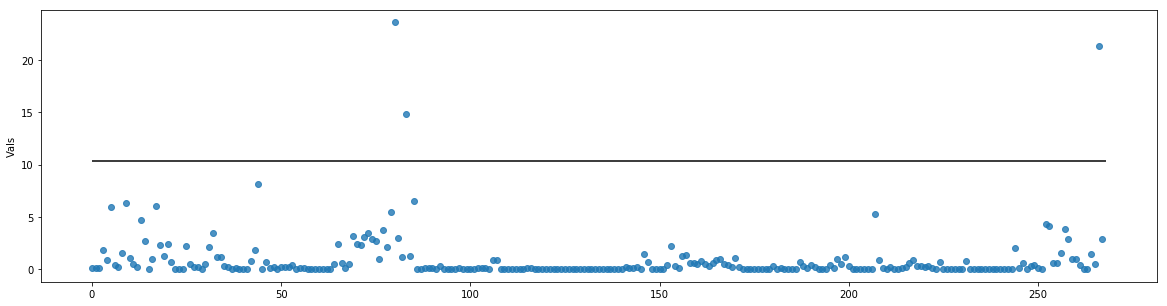

In [252]:
plt.figure(figsize=(20,5))
sns.regplot(x=np.array(np.arange(len(vals))), y=new_frame['Vals'], scatter=True, 
            fit_reg=False)#, lowess=True)
plt.hlines(q, xmin=0, xmax=len(vals))
plt.show()

In [216]:
cross2 = pd.read_csv('BC_dominant_cross.csv', sep=',', header=0, skiprows=[1])
cross2.head()

,phenotype,D1M1,D1M2,D1M3,D1M4,D1M5,D1M6,D1M7,D1M8,D1M9,...,D5M51,D5M52,D5M53,D5M54,D5M55,D5M56,D5M57,D5M58,D5M59,D5M60
0,NaN,0,0.51328404340893,0.953439094591886,4.86603427212685,5.06174384616315,10.7168825529516,15.2733570151031,17.5066576409154,18.0323218042031,...,100.650604013354,102.231718199328,104.391992362216,106.214122446254,107.126231258735,112.867785366252,115.376123506576,116.128040067852,119.586321506649,120
1,1.252148,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
2,0.329969,A,A,A,A,A,A,A,A,H,...,H,H,H,H,H,H,H,H,H,A
3,0.174287,A,A,A,A,A,A,A,A,A,...,H,H,H,H,H,A,A,A,A,A
4,0.126783,H,H,H,H,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H


In [217]:
sign_markers=new_frame[new_frame['Vals']>=q]['markers_ID'].values
print(sign_markers)
cross2[sign_markers].head()

['D2M16' 'D2M19' 'D5M59']


,D2M16,D2M19,D5M59
0,20.3464961028658,26.927122939378,119.586321506649
1,H,H,H
2,A,A,H
3,H,A,A
4,A,A,H


Simulation cell:

%%R
library(qtl)
L=c(50, 75, 100, 80, 120)
set.seed(42)
markers_chr = ceiling(rnorm(5, 1000, 200))
set.seed(42)
mapD=sim.map(L, markers_chr, eq.spacing=F, include.x=F)
plot(mapD)
bc_model = rbind(c(2, 20, 5))
BC_cross = sim.cross(mapD, n.ind=250, type='bc', model = bc_model)
boxplot(BC_cross$pheno)
print(summary(BC_cross))
write.cross(BC_cross, format='csv', filestem='BC_dominant_cross')

When using these parameters the algorithm identify 6 markers (['D2M247' 'D2M248' 'D2M255' 'D2M256' 'D2M269' 'D2M270') significant (coeff > 0) located between 19 and 21 cM.

For this experiment I used the median coefficient and w*s as score

## Problem to optimize:

It seems that the idea behind the algorithm can work. However there is the main problem of computation efficiency. By using the LassoCV approach everything seems faster but still there is room for improvement